# I. Data Preprocessing

In [1]:
import xml.etree.ElementTree as ET 
import numpy as np
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark) # relative? 

landmarks = np.array(landmarks).astype('float32')
bboxes = np.array(bboxes).astype('float32') 

In [2]:
# build a dataset
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

import numpy
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [ ]:
class IbugTrainingDataset(Dataset):
    def __init__(self, img_filenames, bboxes, landmarks, normalize=True, basic_transform=None, albu_transform=None, original=False):
        self.img_filenames = img_filenames
        self.bboxes = bboxes
        self.landmarks = landmarks
        self.basic_transform = basic_transform # resize, totensor, normalize
        self.albu_transform = albu_transform # albumentations
        self.normalize = normalize
        self.is_original = original
        if not self.normalize:
            print('Not normalizing the image')
        if not self.basic_transform:
            print('No basic transformation')
        
    def __len__(self):
        return len(self.img_filenames)
    
    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        opened_img = Image.open(img_path).convert('RGB') # range [0, 255] # shape (H, W, C)
        bounding_box = self.bboxes[idx]
        landmark_ori = self.landmarks[idx] # (68, 2)
        x, y, w, h = bounding_box # left, top, width, height
        cropped_by_bbox = opened_img.crop((x, y, x+w, y+h))
        cropped_by_bbox = np.array(cropped_by_bbox) # range [0, 255]
        # to float32
        cropped_by_bbox = cropped_by_bbox.astype(np.float32)
        if self.normalize:
            cropped_by_bbox = cropped_by_bbox / 255.0 - 0.5 # range [-0.5, 0.5]
            # print(cropped_by_bbox.dtype)
        # adjust the landmark
        # landmark2 = landmark - [x, y] # FIXME: broadcast?
        landmark = np.zeros_like(landmark_ori)
        landmark[:, 0] = landmark_ori[:, 0] - x
        landmark[:, 1] = landmark_ori[:, 1] - y
        # assert np.all(landmark == landmark2)
        # to relative coordinates
        if self.albu_transform:
            transformed = self.albu_transform(image=cropped_by_bbox, keypoints=landmark)
            tfed_im = transformed['image']
            landmark = transformed['keypoints']
        else:
            tfed_im = cropped_by_bbox # (C, H, W)
            
        landmark = torch.tensor(landmark) # shape: (68, 2)
        # relative coordinates
        landmark[:, 0] = landmark[:, 0] / w
        landmark[:, 1] = landmark[:, 1] / h
        # print(tfed_im.shape, w, h)
        # tfed_im = torch.tensor(tfed_im)
        # print(tfed_im.shape)
        if self.basic_transform:
            tfed_im = self.basic_transform(tfed_im)
        else:
            tfed_im = torch.tensor(tfed_im)
        if self.is_original:
            return tfed_im, landmark, bounding_box, landmark_ori
        else:
            return tfed_im, landmark
    
    
basic_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # From (C, H, W) to (C, 224, 224)
    # grayscale
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform = A.Compose([
    A.Affine(rotate=(-15, 15), translate_percent={'x': 0.1, 'y': 0.1}),
    # A.HorizontalFlip(p=0.5),
    # A.GaussNoise(p=0.5), # DO WE NEED THIS?
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

dataset = IbugTrainingDataset(img_filenames, bboxes, landmarks, basic_transform=basic_transform, albu_transform=transform)

# II. Model Architecture
We use ResNet and substitute the first convolutional layer with one that has 1 input channel; we also change the last fully connected layer to output 68*2=136 values.

In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, resnet50, resnet34, resnet101, resnet152, resnext50_32x4d, resnext101_32x8d
# 32x4d, 32x8d means  32 groups, 4 and 8 are the width of each group

In [5]:
class ResNetforFacialLandmarks(nn.Module):
    def __init__(self, in_channels=1, num_landmark=68, dim_landmark=2, resnet=resnet18):
        super(ResNetforFacialLandmarks, self).__init__()
        self.resnet = resnet(pretrained=True)
        # in channel: 1
        # fc layer last dim: 68*2
        self.resnet.conv1 = nn.Conv2d(in_channels,
                                        self.resnet.conv1.out_channels,
                                        kernel_size=self.resnet.conv1.kernel_size,
                                        stride=self.resnet.conv1.stride, 
                                        padding=self.resnet.conv1.padding,
                                        bias=self.resnet.conv1.bias is not None)
        
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_landmark*dim_landmark)
        
    def forward(self, x):
        return self.resnet(x).view(x.size(0), -1, 2) # (N, 68, 2)

# III. Training

We use ResNeXt50 with 32 groups of convolutions (32 paths) with 4 channels each path. Also, we use a LR of 5e-4 with a batch size of 64. We train for 40 epochs.

In [6]:
# plot
import matplotlib.pyplot as plt
from tqdm import tqdm
!nvidia-smi

Sun Dec  1 16:31:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P4             10W /   80W |      15MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetforFacialLandmarks(resnet=resnet50).to(device)
# init
# def init_weights(m):
#     if type(m) == nn.Linear:
#         torch.nn.init.xavier_uniform_(m.weight)
#         m.bias.data.fill_(0.01)
#     elif type(m) == nn.Conv2d:
#         torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         if m.bias is not None:
#             m.bias.data.fill_(0.01)
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss() # TODO: Try Huber loss
LR = 5e-4
# WD = 1e-5
# WD = 0.25
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
epochs = 40
batch_size = 64

# split the dataset
seed_everything(42)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# loaders
seed_everything(42)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
!nvidia-smi

/home/it/miniforge3/envs/180/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/it/miniforge3/envs/180/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sun Dec  1 16:31:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0             14W /   80W |     267MiB /   8188MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# train
train_losses = []
val_losses = []

seed_everything(42)
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(total=len(train_loader), position=0, leave=True)
    loop.set_description(f'Epoch {epoch+1}/{epochs}')
    for i, (images, landmarks) in enumerate(train_loader):
        images = images.to(device)
        landmarks = landmarks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, landmarks)
        # with torch.no_grad():
        #     mae = mae_criterion(outputs, landmarks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # loop.set_postfix(train_loss=loss.item(), mae=mae.item())
        loop.set_postfix(train_loss=loss.item())
        loop.update(1)
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    
    model.eval()
    val_loss = 0.0
    loop = tqdm(total=len(val_loader), position=0, leave=True)
    loop.set_description(f'Epoch {epoch+1}/{epochs}')
    with torch.no_grad():
        for i, (images, landmarks) in enumerate(val_loader):
            images = images.to(device)
            landmarks = landmarks.to(device)
            outputs = model(images)
            loss = criterion(outputs, landmarks)
            val_loss += loss.item()
            loop.set_postfix(val_loss=loss.item())
            loop.update(1)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
    tqdm.write(f'Epoch {epoch+1}/{epochs}, avg_train_loss: {train_loss}, val_loss: {val_loss}')
    # loop.set_postfix(train_loss=train_loss, val_loss=val_loss)
    loop.close()

Epoch 1/40: 100%|██████████| 11/11 [00:08<00:00,  1.37it/s, val_loss=0.00899]


Epoch 1/40, avg_train_loss: 0.018852851650816328, val_loss: 0.008310060694136402


Epoch 2/40: 100%|██████████| 11/11 [00:07<00:00,  1.38it/s, val_loss=0.00886]


Epoch 2/40, avg_train_loss: 0.007972640356920819, val_loss: 0.008447697851806879


Epoch 3/40: 100%|██████████| 11/11 [00:08<00:00,  1.36it/s, val_loss=0.00969]


Epoch 3/40, avg_train_loss: 0.007646983509209562, val_loss: 0.009405132383108139


Epoch 4/40: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s, val_loss=0.00896]


Epoch 4/40, avg_train_loss: 0.007529163678632455, val_loss: 0.008218557023527947


Epoch 5/40: 100%|██████████| 11/11 [00:08<00:00,  1.31it/s, val_loss=0.00747]


Epoch 5/40, avg_train_loss: 0.007394597068072316, val_loss: 0.007536700545725497


Epoch 6/40: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s, val_loss=0.00692]


Epoch 6/40, avg_train_loss: 0.007037055089158264, val_loss: 0.007413690105419268


Epoch 7/40: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s, val_loss=0.00635]


Epoch 7/40, avg_train_loss: 0.0067762716950729805, val_loss: 0.007025174796581268


Epoch 8/40: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s, val_loss=0.00601]


Epoch 8/40, avg_train_loss: 0.006357434131403236, val_loss: 0.0074564946646040135


Epoch 9/40: 100%|██████████| 11/11 [00:07<00:00,  1.38it/s, val_loss=0.0067] 


Epoch 9/40, avg_train_loss: 0.0060995379660991915, val_loss: 0.006150622047822584


Epoch 10/40: 100%|██████████| 11/11 [00:08<00:00,  1.29it/s, val_loss=0.00621]


Epoch 10/40, avg_train_loss: 0.005536605777377461, val_loss: 0.006022086282345382


Epoch 11/40: 100%|██████████| 11/11 [00:08<00:00,  1.29it/s, val_loss=0.00626]


Epoch 11/40, avg_train_loss: 0.005255269022916067, val_loss: 0.005937955045903271


Epoch 12/40: 100%|██████████| 11/11 [00:08<00:00,  1.29it/s, val_loss=0.00671]


Epoch 12/40, avg_train_loss: 0.004982879796521144, val_loss: 0.005679922898045995


Epoch 13/40: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s, val_loss=0.00549]


Epoch 13/40, avg_train_loss: 0.004475103203266701, val_loss: 0.004898785571144385


Epoch 14/40: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s, val_loss=0.00502]


Epoch 14/40, avg_train_loss: 0.004112287803473783, val_loss: 0.004297297024591403


Epoch 15/40: 100%|██████████| 11/11 [00:12<00:00,  1.15s/it, val_loss=0.00556]


Epoch 15/40, avg_train_loss: 0.0038203400896584735, val_loss: 0.004615373253314333


Epoch 16/40: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it, val_loss=0.00487]


Epoch 16/40, avg_train_loss: 0.003628111895213419, val_loss: 0.004180873744189739


Epoch 17/40: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, val_loss=0.00417]


Epoch 17/40, avg_train_loss: 0.0035023877813302458, val_loss: 0.004068931776352904


Epoch 18/40: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it, val_loss=0.00478]


Epoch 18/40, avg_train_loss: 0.003311531890698887, val_loss: 0.004004259276288477


Epoch 19/40: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it, val_loss=0.00403]


Epoch 19/40, avg_train_loss: 0.0032119995275353814, val_loss: 0.0035252857064320283


Epoch 20/40: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it, val_loss=0.00424]


Epoch 20/40, avg_train_loss: 0.0031626046650072045, val_loss: 0.0037541851739991794


Epoch 21/40: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, val_loss=0.0041] 


Epoch 21/40, avg_train_loss: 0.0032506517179191428, val_loss: 0.0036581468937749214


Epoch 22/40: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, val_loss=0.00448]


Epoch 22/40, avg_train_loss: 0.0030953557493085876, val_loss: 0.0038756647316569633


Epoch 23/40: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it, val_loss=0.00394]


Epoch 23/40, avg_train_loss: 0.0031401076443255582, val_loss: 0.0036209360061382704


Epoch 24/40: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it, val_loss=0.00383]


Epoch 24/40, avg_train_loss: 0.0029675951524776346, val_loss: 0.003467920066958124


Epoch 25/40: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it, val_loss=0.00347]


Epoch 25/40, avg_train_loss: 0.003026858534406316, val_loss: 0.003517125394533981


Epoch 26/40: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, val_loss=0.00382]


Epoch 26/40, avg_train_loss: 0.0030572470884393664, val_loss: 0.003372596322812817


Epoch 27/40: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it, val_loss=0.00466]


Epoch 27/40, avg_train_loss: 0.002978001592403397, val_loss: 0.0037805474871261554


Epoch 28/40: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it, val_loss=0.00355]


Epoch 28/40, avg_train_loss: 0.00300387884836961, val_loss: 0.0033109462819993496


Epoch 29/40: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, val_loss=0.00374]


Epoch 29/40, avg_train_loss: 0.0029857738743575804, val_loss: 0.0033459978770803323


Epoch 30/40: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, val_loss=0.00346]


Epoch 30/40, avg_train_loss: 0.002939171282861857, val_loss: 0.0031163709407502956


Epoch 31/40: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it, val_loss=0.00405]


Epoch 31/40, avg_train_loss: 0.0029308439128378286, val_loss: 0.0033915017477490687


Epoch 32/40: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it, val_loss=0.00373]


Epoch 32/40, avg_train_loss: 0.0029330557271679664, val_loss: 0.003181546672501347


Epoch 33/40: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it, val_loss=0.00349]


Epoch 33/40, avg_train_loss: 0.0027909401217178303, val_loss: 0.0029998311815275388


Epoch 34/40: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it, val_loss=0.00332]


Epoch 34/40, avg_train_loss: 0.0027946137694364534, val_loss: 0.0029896376231177287


Epoch 35/40: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it, val_loss=0.00348]


Epoch 35/40, avg_train_loss: 0.002747224432049676, val_loss: 0.002955487548288974


Epoch 36/40: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it, val_loss=0.00338]


Epoch 36/40, avg_train_loss: 0.002802131913027706, val_loss: 0.0030770891092040324


Epoch 37/40: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it, val_loss=0.00373]


Epoch 37/40, avg_train_loss: 0.002772997507449002, val_loss: 0.0031385991976342416


Epoch 38/40: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it, val_loss=0.00352]


Epoch 38/40, avg_train_loss: 0.002819058676052125, val_loss: 0.00322706605815752


Epoch 39/40: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it, val_loss=0.00322]


Epoch 39/40, avg_train_loss: 0.0028777068760741423, val_loss: 0.003088232341476462


Epoch 40/40: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, val_loss=0.00373]

Epoch 40/40, avg_train_loss: 0.0028326106988428596, val_loss: 0.003024941140955145


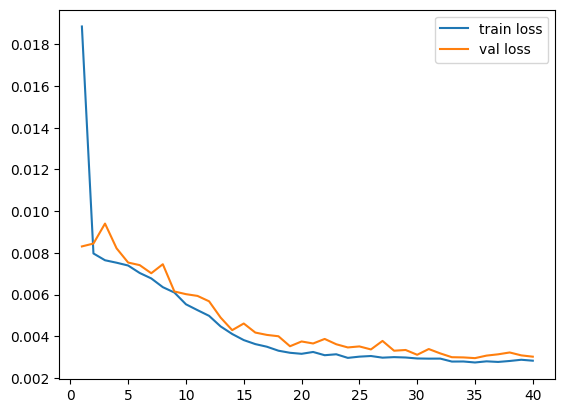

In [9]:
plt.plot(range(1, epochs+1), train_losses, label='train loss')
plt.plot(range(1, epochs+1), val_losses, label='val loss')
plt.legend()
os.makedirs('3', exist_ok=True)
plt.savefig('3/losses.png', dpi=300, bbox_inches='tight')
plt.show()

# IV. Testing

In [10]:
# validation MAE
# mae_criterion = nn.L1Loss()
# model.eval()
# with torch.no_grad():
#     val_mae = 0.0
#     # want original image and landmark
#     val_dataset_original = IbugTrainingDataset(img_filenames, bboxes, landmarks, basic_transform=basic_transform, albu_transform=transform, original=True)
#     val_loader_original = torch.utils.data.DataLoader(val_dataset_original, batch_size=batch_size, shuffle=False, num_workers=16)
#     for i, (images, landmarks, bbox, landmark_ori) in enumerate(val_loader_original):
#         images = images.to(device)
#         landmarks = landmarks.to(device)
#         outputs = model(images)
#         x, y, w, h = bbox[0]
#         outputs[:, :, 0] = outputs[:, :, 0] * w + x
#         outputs[:, :, 1] = outputs[:, :, 1] * h + y
#         mae = mae_criterion(outputs, landmark_ori.to(device))
#         val_mae += mae.item()
#     val_mae /= len(val_loader_original)
#     print(f'Validation MAE: {val_mae}')

In [11]:
# %pip install pandas
import xml.etree.ElementTree as ET 
import numpy as np
import pandas as pd
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test_parsed.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

bboxes = np.array(bboxes).astype('float32') 
print(bboxes.shape)
print(len(img_filenames))
print(img_filenames[0])

(1008, 4)
1008
ibug_300W_large_face_landmark_dataset/helen/trainset/146827737_1.jpg


In [12]:
# we now have img_filenames and bboxes
# for every i in range(len(img_filenames)), 
# we crop the image, resize it to (224, 224), and then feed it to the model
# the output is the landmarks in shape (68, 2)
class IBugTestDataset(Dataset):
    def __init__(self, img_filenames, bboxes, normalize=True, basic_transform=None):
        self.img_filenames = img_filenames
        self.bboxes = bboxes
        self.basic_transform = basic_transform # resize, totensor
        self.normalize = normalize
        
    def __len__(self):
        return len(self.img_filenames)
    
    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        # grayscale
        opened_img = Image.open(img_path).convert('RGB') # range [0, 255] # shape (H, W, C)
        bounding_box = self.bboxes[idx]
        x, y, w, h = bounding_box # left, top, width, height
        cropped_by_bbox = opened_img.crop((x, y, x+w, y+h))
        cropped_by_bbox = np.array(cropped_by_bbox) # range [0, 255]
        if self.normalize:
            cropped_by_bbox = cropped_by_bbox / 255.0 - 0.5
            
        if self.basic_transform:
            cropped_by_bbox = self.basic_transform(cropped_by_bbox)
        else:
            cropped_by_bbox = torch.tensor(cropped_by_bbox).permute(2, 0, 1) # (C, H, W)
        return cropped_by_bbox, bounding_box
    
basic_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)), # From (C, H, W) to (C, 224, 224)
    # grayscale
    transforms.Grayscale(num_output_channels=1), # From (C, H, W) to (1, H, W)
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = IBugTestDataset(img_filenames, bboxes, basic_transform=basic_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# test
model.eval()
preds = []
with torch.no_grad():
    for (images, bbox) in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images) # (N, 68, 2)
        # for every output in outputs, we should get the absolute coordinates
        outputs = outputs.cpu().numpy()
        for j, output in enumerate(outputs):
            x, y, w, h = bbox[j]
            x, y, w, h = int(x), int(y), int(w), int(h)
            output[:, 0] = output[:, 0] * w + x
            output[:, 1] = output[:, 1] * h + y
            # output: (68, 2)
            preds.append(output)


100%|██████████| 16/16 [00:25<00:00,  1.61s/it]


In [14]:
alternating_names = [] # should be 136 * test_size(1008) = 137088
alternating_values = []
counter = 0
for i in range(len(preds)):
    pred = preds[i] # (68, 2)
    
    for j in range(68):
        # alternating_names.append(f'image_{i+1}_keypoints_{j+1}_x')
        alternating_names.append(str(counter))
        counter += 1
        alternating_names.append(str(counter))
        counter += 1
        # alternating_names.append(f'image_{i+1}_keypoints_{j+1}_y')
        
        alternating_values.append(pred[j][0]) # x
        alternating_values.append(pred[j][1]) # y
        
        
        
df = pd.DataFrame({'Id': alternating_names, 'Predicted': alternating_values})

os.makedirs('3', exist_ok=True)
df.to_csv('3/submission.csv', index=False)
!cd 3 && ls -l && kaggle competitions submit -c cs194-26-fall-2022-project-5 -f submission.csv -m "ResNet50, 25 epochs, 5e-4 LR, 64 bs, 0 WD, Huber, 0.1 color jitter, 0.1 translate, 0.1 rotate"


total 8328
-rw-rw-r-- 1 it it  102487 12月  1 17:12 losses.png
-rw-rw-r-- 1 it it  171215 12月  1 16:19 my1.jpg
-rw-rw-r-- 1 it it   76789 12月  1 16:19 my2.jpg
-rw-rw-r-- 1 it it   66916 12月  1 16:19 my3.jpg
-rw-rw-r-- 1 it it 2169756 12月  1 17:12 submission.csv
-rw-rw-r-- 1 it it 5928152 12月  1 16:19 test_first_4_images.png
100%|██████████████████████████████████████| 2.07M/2.07M [00:01<00:00, 1.58MB/s]
Successfully submitted to CS194-26 Fall 2022 Project 5

We visualize 4 test images and their predicted keypoints.

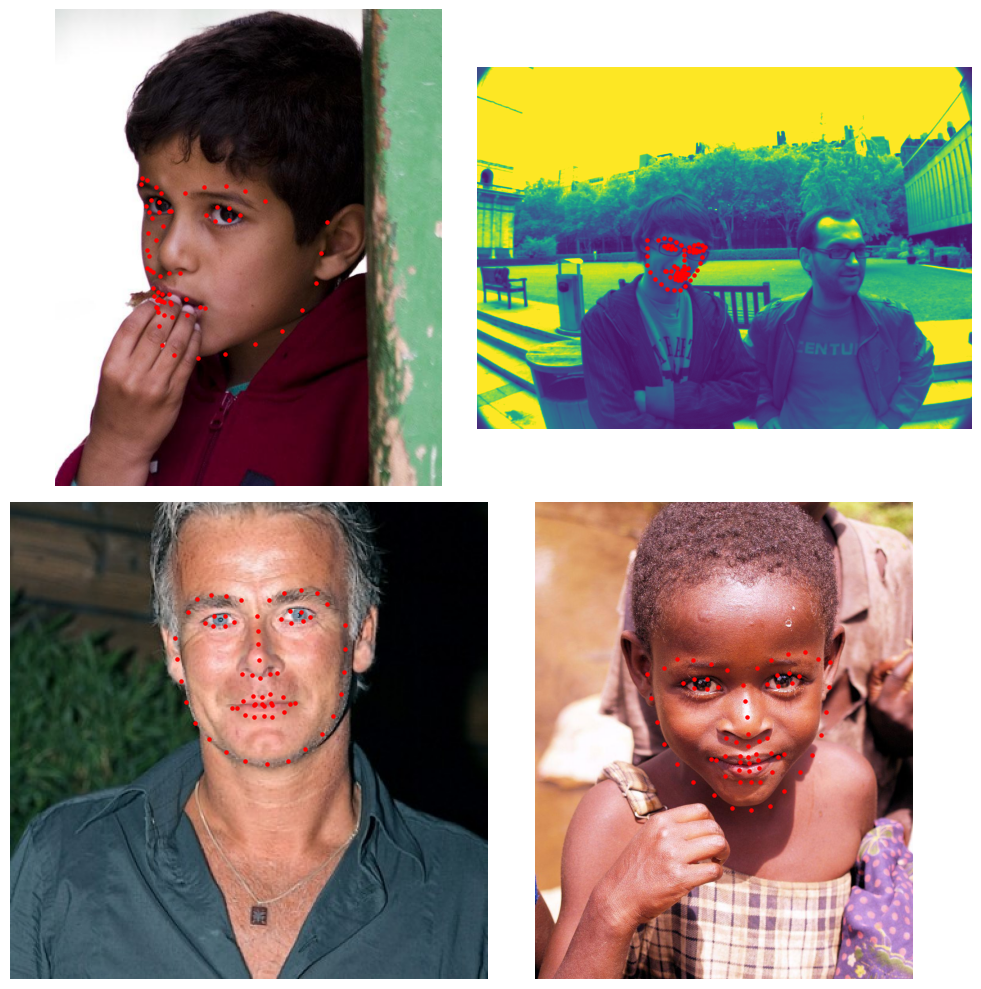

In [15]:
# first 4 images in testset
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for i in range(4):
    img = Image.open(img_filenames[i])
    ax = axes[i]
    ax.imshow(img)
    ax.scatter(preds[i][:, 0], preds[i][:, 1], c='r', s=5)
    ax.axis('off')
    
plt.tight_layout()
plt.savefig('3/test_first_4_images.png', dpi=300, bbox_inches='tight')
plt.show()

On images from my collection...

In [16]:
from PIL import Image

(283, 213)


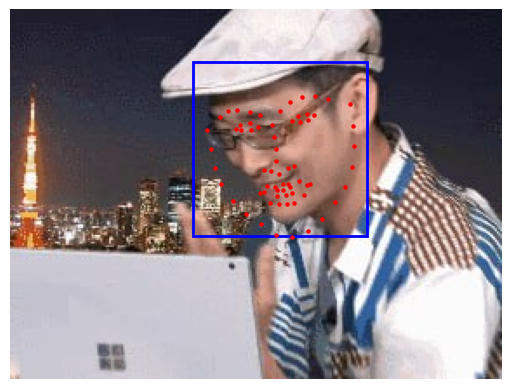

In [17]:
# 1.jpg
with torch.no_grad():
    im1_ori = Image.open('my_ims/1.jpg')
    print(im1_ori.size)
    x, y, w, h = 105, 30, 100, 100
    im1 = im1_ori.crop((x, y, x+w, y+h)).resize((224, 224))
    im1 = im1.convert('L')
    im1 = np.array(im1)
    im1 = im1 / 255.0 - 0.5 # normalize
    im1 = torch.tensor(im1).unsqueeze(0).unsqueeze(0).to(device) # (1, 1, 224, 224)
    im1 = im1.float()
    output = model(im1) # (1, 68, 2)
    output = output.cpu().numpy()
    output = output[0] # (68, 2)
    rect = plt.Rectangle((x, y), w, h, fill=False, color='blue', linewidth=2)
    plt.gca().add_patch(rect)
    # absolute coordinates
    output[:, 0] = output[:, 0] * w + x
    output[:, 1] = output[:, 1] * h + y
    # also show the bounding box
    
    plt.imshow(im1_ori)
    plt.scatter(output[:, 0], output[:, 1], c='r', s=5)
    plt.axis('off')
    plt.savefig('3/my1.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

(429, 375)


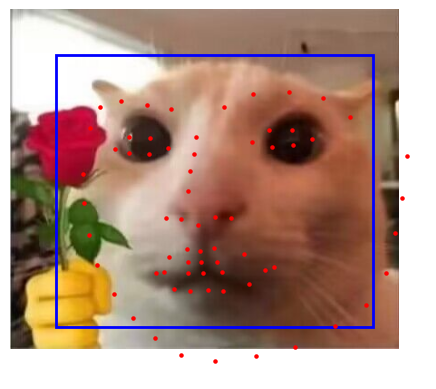

In [37]:
# 2.jpg
with torch.no_grad():
    im2_ori = Image.open('my_ims/2.jpg')
    print(im2_ori.size)
    x, y, w, h = 50, 50, 350, 300
    im2 = im2_ori.crop((x, y, x+w, y+h)).resize((224, 224))
    im2 = im2.convert('L')
    im2 = np.array(im2)
    im2 = im2 / 255.0 - 0.5 # normalize
    im2 = torch.tensor(im2).unsqueeze(0).unsqueeze(0).to(device) # (1, 1, 224, 224)
    im2 = im2.float()
    output = model(im2) # (1, 68, 2)
    output = output.cpu().numpy()
    output = output[0] # (68, 2)
    rect = plt.Rectangle((x, y), w, h, fill=False, color='blue', linewidth=2)
    plt.gca().add_patch(rect)
    # absolute coordinates
    output[:, 0] = output[:, 0] * w + x
    output[:, 1] = output[:, 1] * h + y
    # also show the bounding box
    
    plt.imshow(im2_ori)
    plt.scatter(output[:, 0], output[:, 1], c='r', s=5)
    plt.axis('off')
    plt.savefig('3/my2.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

(467, 453)


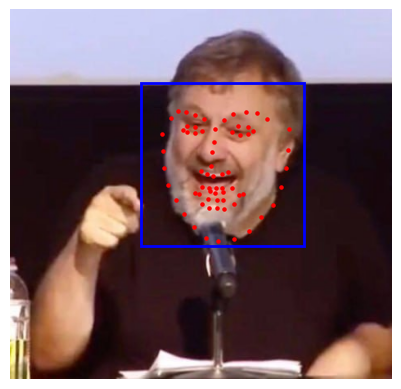

In [33]:
# 3.jpg
with torch.no_grad():
    im3_ori = Image.open('my_ims/3.jpg')
    print(im3_ori.size)
    x, y, w, h = 160, 90, 200, 200
    im3 = im3_ori.crop((x, y, x+w, y+h)).resize((224, 224))
    im3 = im3.convert('L')
    im3 = np.array(im3)
    im3 = im3 / 255.0 - 0.5 # normalize
    im3 = torch.tensor(im3).unsqueeze(0).unsqueeze(0).to(device) # (1, 1, 224, 224)
    im3 = im3.float()
    output = model(im3) # (1, 68, 2)
    output = output.cpu().numpy()
    output = output[0] # (68, 2)
    rect = plt.Rectangle((x, y), w, h, fill=False, color='blue', linewidth=2)
    plt.gca().add_patch(rect)
    # absolute coordinates
    output[:, 0] = output[:, 0] * w + x
    output[:, 1] = output[:, 1] * h + y
    # also show the bounding box
    
    plt.imshow(im3_ori)
    plt.scatter(output[:, 0], output[:, 1], c='r', s=5)
    plt.axis('off')
    plt.savefig('3/my3.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()